In [35]:
#Importamos las liberías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import seaborn as sns
%matplotlib inline

from pandas import read_csv
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
#import pydotplus
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#import warnings
#warnings.filterwarnings("ignore")

## PREPARACIÓN DE DATOS

In [36]:
#Cargamos el csv
df=pd.read_csv("cancer_mama.csv",sep=",")
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [37]:
#Ver los valores de cada columna
for i in df.columns:
    print(df[i].unique())

[   842302    842517  84300903  84348301  84358402    843786    844359
  84458202    844981  84501001    845636  84610002    846226    846381
  84667401  84799002    848406  84862001    849014   8510426   8510653
   8510824   8511133    851509    852552    852631    852763    852781
    852973    853201    853401    853612  85382601    854002    854039
    854253    854268    854941    855133    855138    855167    855563
    855625    856106  85638502    857010  85713702     85715    857155
    857156    857343    857373    857374    857392    857438  85759902
    857637    857793    857810    858477    858970    858981    858986
    859196  85922302    859283    859464    859465    859471    859487
    859575    859711    859717    859983   8610175   8610404   8610629
   8610637   8610862   8610908    861103   8611161   8611555   8611792
   8612080   8612399  86135501  86135502    861597    861598    861648
    861799    861853    862009    862028     86208     86211    862261
    86

In [38]:
#Vemos los valores que tiene cada columna y cuantas veces aparece cada uno de ellos
for i in df.columns:
    print(i,df[i].value_counts())

id 842302     1
90250      1
901315     1
9013579    1
9013594    1
          ..
873885     1
873843     1
873701     1
873593     1
92751      1
Name: id, Length: 569, dtype: int64
diagnosis B    357
M    212
Name: diagnosis, dtype: int64
radius_mean 12.34    4
11.71    3
12.46    3
13.05    3
10.26    3
        ..
12.23    1
14.45    1
19.18    1
18.08    1
7.76     1
Name: radius_mean, Length: 456, dtype: int64
texture_mean 20.52    3
16.85    3
16.84    3
19.83    3
14.93    3
        ..
18.58    1
15.11    1
22.41    1
14.92    1
24.54    1
Name: texture_mean, Length: 479, dtype: int64
perimeter_mean 82.61     3
87.76     3
134.70    3
93.97     2
82.69     2
         ..
127.50    1
90.63     1
82.53     1
100.40    1
47.92     1
Name: perimeter_mean, Length: 522, dtype: int64
area_mean 512.2     3
1075.0    2
582.7     2
399.8     2
641.2     2
         ..
507.4     1
609.9     1
463.7     1
428.9     1
181.0     1
Name: area_mean, Length: 539, dtype: int64
smoothness_mean 0.1007

In [39]:
#Información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [40]:
#Guardamos el dataset como csv
df.to_csv("cancer_mama_py.csv", index=False)

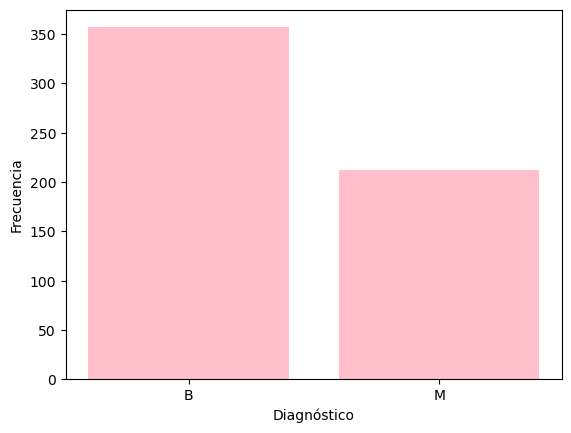

In [41]:
# Calcula la frecuencia de los valores de clase en todo el DataFrame
frecuencia_clase = df['diagnosis'].value_counts()

# Crea un gráfico de barras para visualizar la frecuencia de los valores de clase
plt.bar(frecuencia_clase.index, frecuencia_clase.values, color="pink")
plt.xlabel('Diagnóstico')
plt.ylabel('Frecuencia')
plt.show()


# PREPROCESAMIENTO

In [42]:
# Convertir diagnosis a numérico
df.diagnosis = df.diagnosis.replace({"B": 0, "M": 1})

# Dividimos entrada y salida
x=df.iloc[:,2:32]
print(x)
y=df[["diagnosis"]]
# Dividimos en datos de entrenamiento y de validación
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

# Tamaños
x.shape, y.shape

x_train.shape, y_train.shape

x_test.shape, y_test.shape

# Calculamos el máximo y mínimo
maxs = np.max(x_train, axis=0)
mins = np.min(x_train, axis=0)

ranges = maxs - mins

# Normalizamos las variables
x_train = (x_train - mins) / ranges
x_test = (x_test - mins) / ranges

# Calcula las frecuencias de clase en y_train
class_frequencies = y_train.value_counts()

# Calcula los pesos para cada clase  
class_weights = {cls: 1.0 / freq for cls, freq in class_frequencies.items()}
class_weights_int = {int(cls[0]): weight for cls, weight in class_weights.items()}

     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     compactness_mean  concavity_mean  concave points_mean  sym

# MODELOS

## Árbol de decisión

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

cross_value:  0.927632850241546


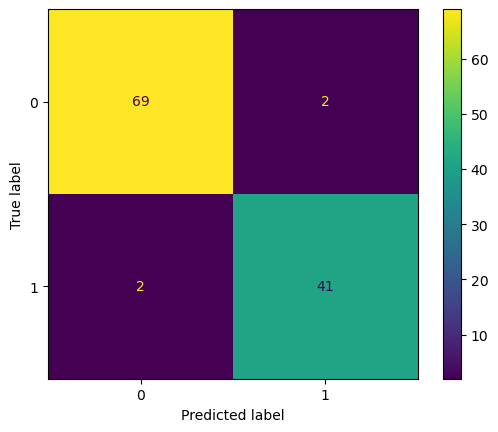

In [43]:
# modelo genérico
DT = DecisionTreeClassifier(class_weight=class_weights_int)
# entrenamos el modelo
DT.fit(x_train, y_train)
# hacer predicciones
pred_DT = DT.predict(x_test)
# informe
print(classification_report(y_test,pred_DT))
# cross value
kfold = StratifiedKFold(10)
score = cross_val_score(
    DT, x_train, y_train, cv=kfold, scoring="accuracy"
)
DT_prec=score.mean()
print("cross_value: ", DT_prec)
# matriz de confusión
mat_conf = confusion_matrix(y_test, pred_DT)
ConfusionMatrixDisplay(mat_conf).plot()
plt.show()

In [44]:
# ver opciones con otros parametros
DT_combinaciones={}
# parametros
splitter_ = ["best", "random"]
criterion_ = ["gini", "entropy"]
max_features_ = [None,"sqrt", "log2"]
porc_ = [0.2, 0.3]
# combinaciones
for c in criterion_:
    for m in max_features_:
        for s in splitter_:
            for p in [1, 2]:
                vector_parametros=[c,m,s,porc_[p-1]]
                # dividimos las instancias
                x_train, x_test, y_train, y_test = train_test_split(
                    x, y, test_size=porc_[p - 1], random_state=42, shuffle=True
                )
                # modelo
                DT = DecisionTreeClassifier(criterion=c, max_features=m, splitter=s, class_weight=class_weights_int)
                # entrenamos el modelo
                DT.fit(x_train, y_train)
                # hacer predicciones
                predicciones_DT = DT.predict(x_test)
                # calculamos la exactitud del modelo
                acc_1 = accuracy_score(y_test, predicciones_DT)
                # cross value
                kfold = StratifiedKFold(10)
                score = cross_val_score(DT, x_train, y_train, cv=kfold, scoring="accuracy")
                print(
                    c,
                    ",",
                    m,
                    "y",
                    s,
                    "(",
                    porc_[p - 1],
                    ")",
                    "-> accuracy_score: ",
                    acc_1,
                    "//",
                    "cross_value: ",
                    score.mean()
                )
                # añadimos al diccionario esta combinación
                DT_combinaciones[score.mean()]=vector_parametros
                
# calculamos la precisión máxima
DT_max_prec = max(DT_combinaciones)
# miramos con que parámetros se consigue esta precisión
DT_mejor_vector_parametros = DT_combinaciones[DT_max_prec]
print("mejores resultados con los parametros -> ",DT_mejor_vector_parametros)

gini , None y best ( 0.2 ) -> accuracy_score:  0.956140350877193 // cross_value:  0.9209178743961353
gini , None y best ( 0.3 ) -> accuracy_score:  0.9181286549707602 // cross_value:  0.9147435897435898
gini , None y random ( 0.2 ) -> accuracy_score:  0.9385964912280702 // cross_value:  0.9253140096618357
gini , None y random ( 0.3 ) -> accuracy_score:  0.9239766081871345 // cross_value:  0.9217948717948719
gini , sqrt y best ( 0.2 ) -> accuracy_score:  0.9473684210526315 // cross_value:  0.9078260869565218
gini , sqrt y best ( 0.3 ) -> accuracy_score:  0.9122807017543859 // cross_value:  0.924423076923077
gini , sqrt y random ( 0.2 ) -> accuracy_score:  0.956140350877193 // cross_value:  0.898743961352657
gini , sqrt y random ( 0.3 ) -> accuracy_score:  0.9532163742690059 // cross_value:  0.9194871794871796
gini , log2 y best ( 0.2 ) -> accuracy_score:  0.9649122807017544 // cross_value:  0.9252657004830919
gini , log2 y best ( 0.3 ) -> accuracy_score:  0.9473684210526315 // cross_val

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       108
           1       0.96      0.86      0.91        63

    accuracy                           0.94       171
   macro avg       0.94      0.92      0.93       171
weighted avg       0.94      0.94      0.93       171

cross_value:  0.914551282051282


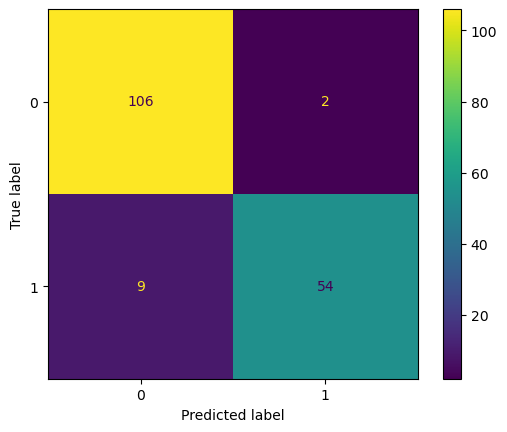

In [45]:
# mejor modelo (utilizando el vector conseguido anteriormente)
DT_mejor = DecisionTreeClassifier(criterion=DT_mejor_vector_parametros[0], max_features=DT_mejor_vector_parametros[1], splitter=DT_mejor_vector_parametros[2], class_weight=class_weights_int)
# dividimos las instancias 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=DT_mejor_vector_parametros[3], random_state=42, shuffle=True)
# entrenamos el modelo
DT_mejor.fit(x_train, y_train)
# hacer predicciones
pred_DT_mejor = DT_mejor.predict(x_test)
# informe
print(classification_report(y_test,pred_DT_mejor))
# cross value
kfold = StratifiedKFold(10)
score = cross_val_score(
    DT_mejor, x_train, y_train, cv=kfold, scoring="accuracy"
)
DT_mejor_prec=score.mean()
print("cross_value: ", DT_mejor_prec)
# matriz de confusión
mat_conf = confusion_matrix(y_test, pred_DT_mejor)
ConfusionMatrixDisplay(mat_conf).plot()
plt.show()

## Random forest

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       108
           1       0.97      0.95      0.96        63

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171

cross_value:  0.9547435897435896


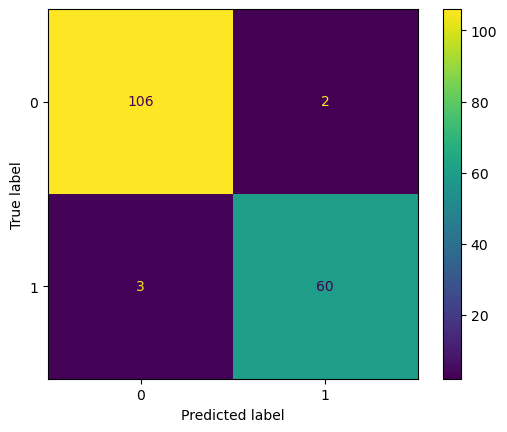

In [46]:
# modelo genérico
y_ravel= np.ravel(y)
RF = RandomForestClassifier(class_weight=class_weights_int)
# entrenamos el modelo
y_train=y_train.values.ravel()
RF.fit(x_train, y_train)
# hacer predicciones
pred_RF = RF.predict(x_test)
# informe
print(classification_report(y_test,pred_RF,zero_division=0))
# cross value
kfold = StratifiedKFold(10)
score = cross_val_score(
    RF, x_train, y_train, cv=kfold, scoring="accuracy"
)
RF_prec=score.mean()
print("cross_value: ", RF_prec)
# matriz de confusión
mat_conf = confusion_matrix(y_test, pred_RF)
ConfusionMatrixDisplay(mat_conf).plot()
plt.show()

In [47]:
# ver opciones con otros parámetros
RF_combinaciones={}
# parametros
criterion_ = ["gini", "entropy"]
max_features_ = [None,"sqrt", "log2"]
porc_ = [0.2, 0.3]
# combinaciones
for c in criterion_:
    for m in max_features_:
        for p in [1, 2]:
            vector_parametros=[c,m,porc_[p-1]]
            # dividimos las instancias
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=porc_[p - 1], random_state=42, shuffle=True)
            y_train=y_train.values.ravel()
            # modelo
            RF = RandomForestClassifier(criterion=c, max_features=m, class_weight=class_weights_int)
            # entrenamos el modelo
            RF.fit(x_train, y_train)
            # hacer predicciones
            predicciones_RF = RF.predict(x_test)
            # calculamos la exactitud del modelo
            acc_1 = accuracy_score(y_test, predicciones_RF)
            # cross value
            kfold = StratifiedKFold(10)
            score = cross_val_score(RF, x_train, y_train, cv=kfold, scoring="accuracy")
            print(
                c,
                "y",
                m,
                "(",
                porc_[p - 1],
                ")",
                "-> accuracy_score: ",
                acc_1,
                "//",
                "cross_value: ",
                score.mean()
            )
            # añadimos al diccionario esta combinación
            RF_combinaciones[score.mean()]=vector_parametros
                
# calculamos la precisión máxima
RF_max_prec = max(RF_combinaciones)
# miramos con que parámetros se consigue esta precisión
RF_mejor_vector_parametros = RF_combinaciones[RF_max_prec]
print("mejores resultados con los parametros -> ",RF_mejor_vector_parametros)

gini y None ( 0.2 ) -> accuracy_score:  0.9736842105263158 // cross_value:  0.9604830917874396
gini y None ( 0.3 ) -> accuracy_score:  0.9590643274853801 // cross_value:  0.9498076923076922
gini y sqrt ( 0.2 ) -> accuracy_score:  0.9649122807017544 // cross_value:  0.9671497584541063
gini y sqrt ( 0.3 ) -> accuracy_score:  0.9649122807017544 // cross_value:  0.9547435897435896
gini y log2 ( 0.2 ) -> accuracy_score:  0.9649122807017544 // cross_value:  0.96487922705314
gini y log2 ( 0.3 ) -> accuracy_score:  0.9707602339181286 // cross_value:  0.9496794871794872
entropy y None ( 0.2 ) -> accuracy_score:  0.9736842105263158 // cross_value:  0.9582608695652175
entropy y None ( 0.3 ) -> accuracy_score:  0.9649122807017544 // cross_value:  0.9571153846153846
entropy y sqrt ( 0.2 ) -> accuracy_score:  0.9649122807017544 // cross_value:  0.9604347826086956
entropy y sqrt ( 0.3 ) -> accuracy_score:  0.9824561403508771 // cross_value:  0.9571153846153846
entropy y log2 ( 0.2 ) -> accuracy_score

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

cross_value:  0.96487922705314


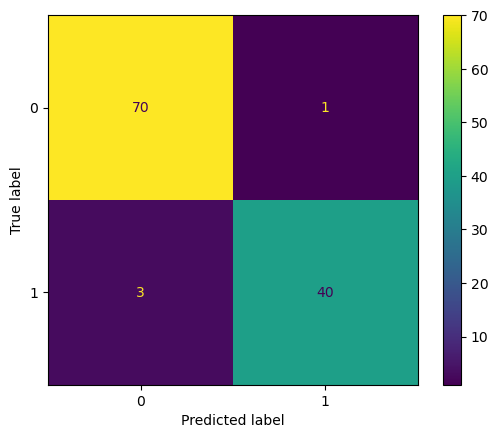

In [48]:
# mejor modelo (utilizando el vector conseguido anteriormente)
RF_mejor = RandomForestClassifier(criterion=RF_mejor_vector_parametros[0], max_features=RF_mejor_vector_parametros[1], class_weight=class_weights_int)
# dividimos las instancias 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=RF_mejor_vector_parametros[2], random_state=42, shuffle=True)
y_train=y_train.values.ravel()
# entrenamos el modelo
RF_mejor.fit(x_train, y_train)
# hacer predicciones
pred_RF_mejor = RF_mejor.predict(x_test)
# informe
print(classification_report(y_test,pred_RF_mejor))
# cross value
kfold = StratifiedKFold(10)
score = cross_val_score(
    RF_mejor, x_train, y_train, cv=kfold, scoring="accuracy"
)
RF_mejor_prec=score.mean()
print("cross_value: ", RF_mejor_prec)
# matriz de confusión
mat_conf = confusion_matrix(y_test, pred_RF_mejor)
ConfusionMatrixDisplay(mat_conf).plot()
plt.show()

## Redes neuronales

Epoch 1/10
15/15 [==============================] - 1s 15ms/step - loss: 0.4847 - accuracy: 0.8154 - val_loss: 0.3210 - val_accuracy: 0.9649
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 0.2512 - accuracy: 0.9516 - val_loss: 0.1744 - val_accuracy: 0.9649
Epoch 3/10
15/15 [==============================] - 0s 4ms/step - loss: 0.1588 - accuracy: 0.9582 - val_loss: 0.1100 - val_accuracy: 0.9649
Epoch 4/10
15/15 [==============================] - 0s 8ms/step - loss: 0.1171 - accuracy: 0.9648 - val_loss: 0.0858 - val_accuracy: 0.9737
Epoch 5/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0956 - accuracy: 0.9736 - val_loss: 0.0744 - val_accuracy: 0.9737
Epoch 6/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0811 - accuracy: 0.9802 - val_loss: 0.0704 - val_accuracy: 0.9737
Epoch 7/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0725 - accuracy: 0.9824 - val_loss: 0.0675 - val_accuracy: 0.9737
Epoch 8/10
15/15 [=

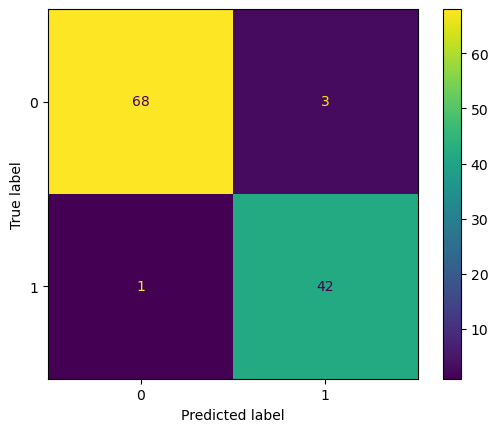

Epoch 1/10
15/15 [==============================] - 1s 30ms/step - loss: 0.0524 - accuracy: 0.9846 - val_loss: 0.0666 - val_accuracy: 0.9649
Epoch 2/10
15/15 [==============================] - 0s 6ms/step - loss: 0.0521 - accuracy: 0.9846 - val_loss: 0.0666 - val_accuracy: 0.9649
Epoch 3/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0519 - accuracy: 0.9846 - val_loss: 0.0671 - val_accuracy: 0.9649
Epoch 4/10
15/15 [==============================] - 0s 7ms/step - loss: 0.0517 - accuracy: 0.9846 - val_loss: 0.0670 - val_accuracy: 0.9649
Epoch 5/10
15/15 [==============================] - 0s 7ms/step - loss: 0.0514 - accuracy: 0.9846 - val_loss: 0.0669 - val_accuracy: 0.9649
Epoch 6/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0512 - accuracy: 0.9846 - val_loss: 0.0668 - val_accuracy: 0.9649
Epoch 7/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0510 - accuracy: 0.9846 - val_loss: 0.0667 - val_accuracy: 0.9649
Epoch 8/10
15/15 [=

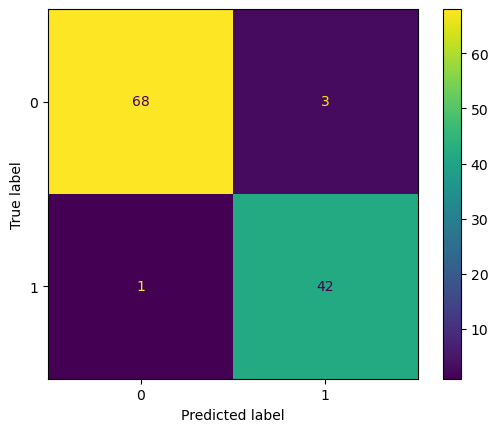

Epoch 1/10
15/15 [==============================] - 2s 31ms/step - loss: 0.0526 - accuracy: 0.9824 - val_loss: 0.0650 - val_accuracy: 0.9649
Epoch 2/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0454 - accuracy: 0.9890 - val_loss: 0.0693 - val_accuracy: 0.9649
Epoch 3/10
15/15 [==============================] - 0s 6ms/step - loss: 0.0416 - accuracy: 0.9868 - val_loss: 0.0684 - val_accuracy: 0.9649
Epoch 4/10
15/15 [==============================] - 0s 7ms/step - loss: 0.0374 - accuracy: 0.9890 - val_loss: 0.0666 - val_accuracy: 0.9737
Epoch 5/10
15/15 [==============================] - 0s 7ms/step - loss: 0.0345 - accuracy: 0.9890 - val_loss: 0.0698 - val_accuracy: 0.9737
Epoch 6/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0313 - accuracy: 0.9934 - val_loss: 0.0731 - val_accuracy: 0.9737
Epoch 7/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0281 - accuracy: 0.9934 - val_loss: 0.0690 - val_accuracy: 0.9737
Epoch 8/10
15/15 [=

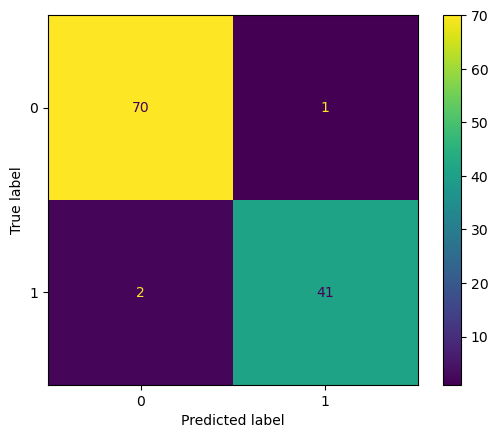

Epoch 1/10
15/15 [==============================] - 2s 30ms/step - loss: 0.0189 - accuracy: 0.9956 - val_loss: 0.0748 - val_accuracy: 0.9737
Epoch 2/10
15/15 [==============================] - 0s 6ms/step - loss: 0.0188 - accuracy: 0.9934 - val_loss: 0.0747 - val_accuracy: 0.9737
Epoch 3/10
15/15 [==============================] - 0s 7ms/step - loss: 0.0188 - accuracy: 0.9934 - val_loss: 0.0747 - val_accuracy: 0.9737
Epoch 4/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0188 - accuracy: 0.9934 - val_loss: 0.0747 - val_accuracy: 0.9737
Epoch 5/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0187 - accuracy: 0.9934 - val_loss: 0.0747 - val_accuracy: 0.9737
Epoch 6/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0187 - accuracy: 0.9934 - val_loss: 0.0747 - val_accuracy: 0.9737
Epoch 7/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0187 - accuracy: 0.9934 - val_loss: 0.0747 - val_accuracy: 0.9737
Epoch 8/10
15/15 [=

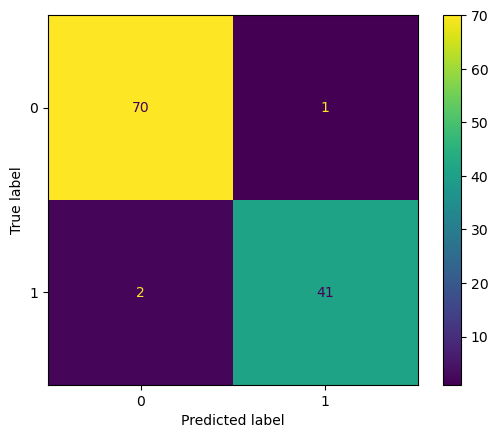

Epoch 1/10
15/15 [==============================] - 2s 28ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.0768 - val_accuracy: 0.9737
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0181 - accuracy: 0.9934 - val_loss: 0.0770 - val_accuracy: 0.9737
Epoch 3/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0174 - accuracy: 0.9934 - val_loss: 0.0785 - val_accuracy: 0.9737
Epoch 4/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0162 - accuracy: 0.9956 - val_loss: 0.0781 - val_accuracy: 0.9737
Epoch 5/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0154 - accuracy: 0.9978 - val_loss: 0.0796 - val_accuracy: 0.9737
Epoch 6/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0150 - accuracy: 0.9978 - val_loss: 0.0795 - val_accuracy: 0.9737
Epoch 7/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0146 - accuracy: 0.9978 - val_loss: 0.0796 - val_accuracy: 0.9737
Epoch 8/10
15/15 [=

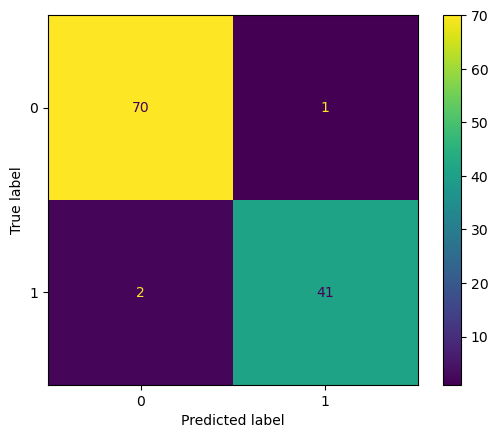

Epoch 1/10
15/15 [==============================] - 1s 16ms/step - loss: 0.5421 - accuracy: 0.7099 - val_loss: 0.3362 - val_accuracy: 0.9474
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 0.2370 - accuracy: 0.9604 - val_loss: 0.1231 - val_accuracy: 0.9649
Epoch 3/10
15/15 [==============================] - 0s 5ms/step - loss: 0.1067 - accuracy: 0.9692 - val_loss: 0.0705 - val_accuracy: 0.9649
Epoch 4/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0737 - accuracy: 0.9824 - val_loss: 0.0650 - val_accuracy: 0.9649
Epoch 5/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0624 - accuracy: 0.9802 - val_loss: 0.0612 - val_accuracy: 0.9649
Epoch 6/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0527 - accuracy: 0.9846 - val_loss: 0.0635 - val_accuracy: 0.9649
Epoch 7/10
15/15 [==============================] - 0s 7ms/step - loss: 0.0483 - accuracy: 0.9846 - val_loss: 0.0609 - val_accuracy: 0.9737
Epoch 8/10
15/15 [=

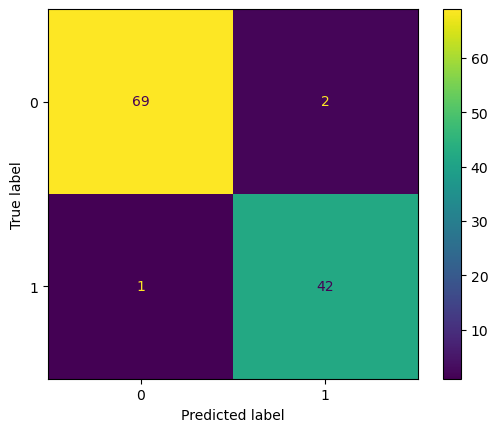

Epoch 1/10
15/15 [==============================] - 1s 31ms/step - loss: 0.0280 - accuracy: 0.9934 - val_loss: 0.0731 - val_accuracy: 0.9737
Epoch 2/10
15/15 [==============================] - 0s 7ms/step - loss: 0.0277 - accuracy: 0.9934 - val_loss: 0.0724 - val_accuracy: 0.9737
Epoch 3/10
15/15 [==============================] - 0s 7ms/step - loss: 0.0275 - accuracy: 0.9934 - val_loss: 0.0714 - val_accuracy: 0.9737
Epoch 4/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0272 - accuracy: 0.9934 - val_loss: 0.0708 - val_accuracy: 0.9737
Epoch 5/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0271 - accuracy: 0.9934 - val_loss: 0.0706 - val_accuracy: 0.9737
Epoch 6/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0269 - accuracy: 0.9934 - val_loss: 0.0713 - val_accuracy: 0.9737
Epoch 7/10
15/15 [==============================] - 0s 7ms/step - loss: 0.0268 - accuracy: 0.9934 - val_loss: 0.0704 - val_accuracy: 0.9737
Epoch 8/10
15/15 [=

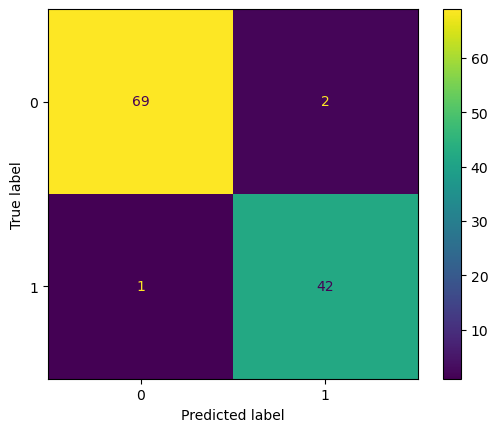

Epoch 1/10
15/15 [==============================] - 2s 32ms/step - loss: 0.0317 - accuracy: 0.9934 - val_loss: 0.0662 - val_accuracy: 0.9737
Epoch 2/10
15/15 [==============================] - 0s 7ms/step - loss: 0.0233 - accuracy: 0.9956 - val_loss: 0.0732 - val_accuracy: 0.9737
Epoch 3/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0224 - accuracy: 0.9934 - val_loss: 0.0731 - val_accuracy: 0.9649
Epoch 4/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0196 - accuracy: 0.9912 - val_loss: 0.0733 - val_accuracy: 0.9649
Epoch 5/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0152 - accuracy: 0.9956 - val_loss: 0.0793 - val_accuracy: 0.9649
Epoch 6/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0135 - accuracy: 0.9934 - val_loss: 0.0812 - val_accuracy: 0.9649
Epoch 7/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0114 - accuracy: 0.9956 - val_loss: 0.1135 - val_accuracy: 0.9649
Epoch 8/10
15/15 [=

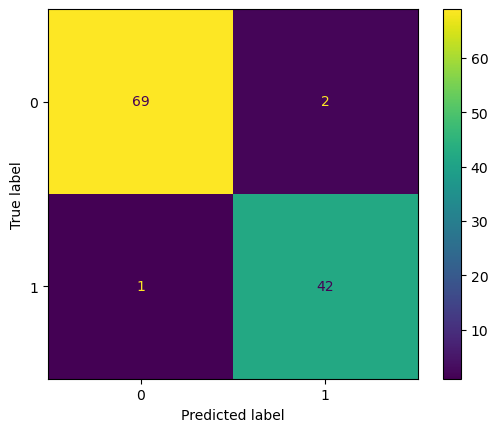

Epoch 1/10
15/15 [==============================] - 2s 33ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.1091 - val_accuracy: 0.9737
Epoch 2/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.1082 - val_accuracy: 0.9737
Epoch 3/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.1076 - val_accuracy: 0.9737
Epoch 4/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.1070 - val_accuracy: 0.9737
Epoch 5/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.1064 - val_accuracy: 0.9737
Epoch 6/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.1059 - val_accuracy: 0.9649
Epoch 7/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.1054 - val_accuracy: 0.9649
Epoch 8/10
15/15 [=

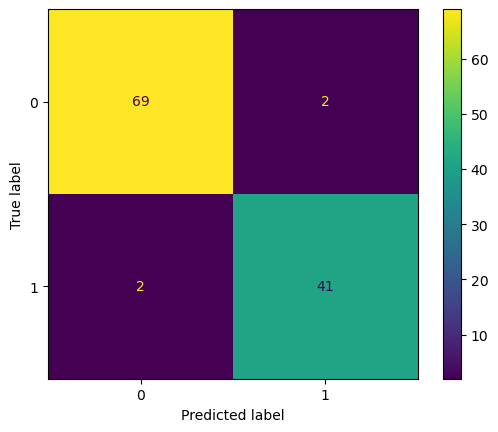

Epoch 1/10
15/15 [==============================] - 2s 14ms/step - loss: 0.0041 - accuracy: 0.9978 - val_loss: 0.0963 - val_accuracy: 0.9649
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.1021 - val_accuracy: 0.9649
Epoch 3/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1018 - val_accuracy: 0.9649
Epoch 4/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1031 - val_accuracy: 0.9649
Epoch 5/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1047 - val_accuracy: 0.9649
Epoch 6/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1059 - val_accuracy: 0.9649
Epoch 7/10
15/15 [==============================] - 0s 10ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1058 - val_accuracy: 0.9649
Epoch 8/10
15/15 [

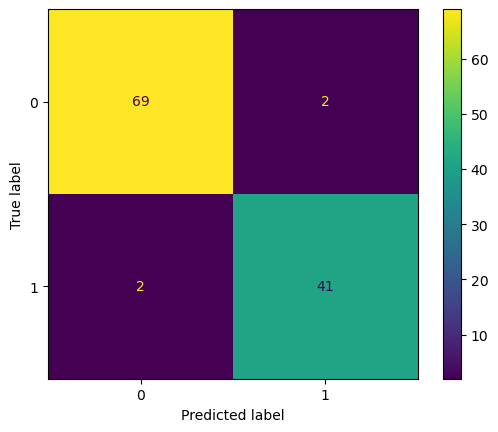

Epoch 1/10
15/15 [==============================] - 1s 15ms/step - loss: 0.5451 - accuracy: 0.8571 - val_loss: 0.3394 - val_accuracy: 0.9561
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 0.2073 - accuracy: 0.9560 - val_loss: 0.1033 - val_accuracy: 0.9737
Epoch 3/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0933 - accuracy: 0.9714 - val_loss: 0.0781 - val_accuracy: 0.9649
Epoch 4/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0732 - accuracy: 0.9736 - val_loss: 0.0741 - val_accuracy: 0.9649
Epoch 5/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0590 - accuracy: 0.9802 - val_loss: 0.0724 - val_accuracy: 0.9649
Epoch 6/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0500 - accuracy: 0.9846 - val_loss: 0.0866 - val_accuracy: 0.9649
Epoch 7/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0417 - accuracy: 0.9868 - val_loss: 0.0941 - val_accuracy: 0.9561
Epoch 8/10
15/15 [=

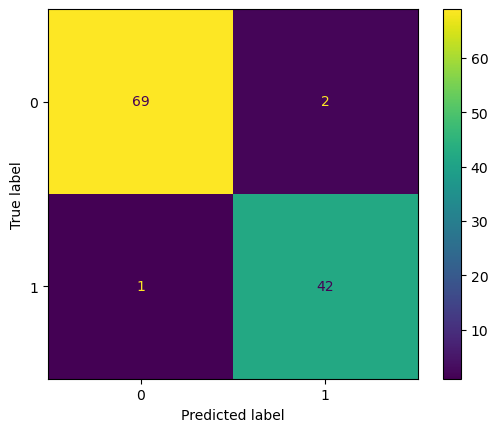

Epoch 1/10
15/15 [==============================] - 2s 33ms/step - loss: 0.0212 - accuracy: 0.9934 - val_loss: 0.0924 - val_accuracy: 0.9737
Epoch 2/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0208 - accuracy: 0.9956 - val_loss: 0.0932 - val_accuracy: 0.9737
Epoch 3/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0206 - accuracy: 0.9956 - val_loss: 0.0940 - val_accuracy: 0.9737
Epoch 4/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0203 - accuracy: 0.9956 - val_loss: 0.0948 - val_accuracy: 0.9737
Epoch 5/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0201 - accuracy: 0.9956 - val_loss: 0.0952 - val_accuracy: 0.9737
Epoch 6/10
15/15 [==============================] - 0s 10ms/step - loss: 0.0199 - accuracy: 0.9956 - val_loss: 0.0953 - val_accuracy: 0.9737
Epoch 7/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0197 - accuracy: 0.9956 - val_loss: 0.0958 - val_accuracy: 0.9737
Epoch 8/10
15/15 [

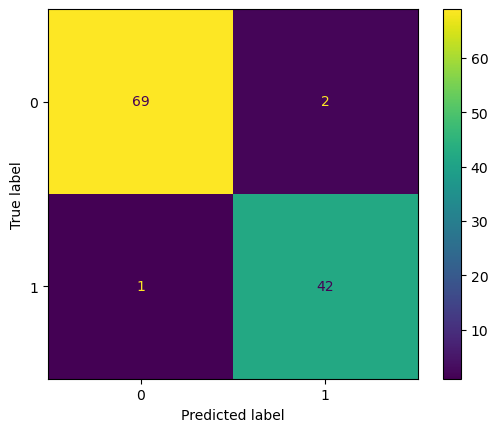

Epoch 1/10
15/15 [==============================] - 3s 35ms/step - loss: 0.0223 - accuracy: 0.9956 - val_loss: 0.1160 - val_accuracy: 0.9649
Epoch 2/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0188 - accuracy: 0.9956 - val_loss: 0.1010 - val_accuracy: 0.9737
Epoch 3/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0170 - accuracy: 0.9956 - val_loss: 0.1070 - val_accuracy: 0.9737
Epoch 4/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0124 - accuracy: 0.9956 - val_loss: 0.1272 - val_accuracy: 0.9737
Epoch 5/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0089 - accuracy: 0.9956 - val_loss: 0.0923 - val_accuracy: 0.9737
Epoch 6/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0079 - accuracy: 0.9956 - val_loss: 0.1327 - val_accuracy: 0.9737
Epoch 7/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1128 - val_accuracy: 0.9737
Epoch 8/10
15/15 [=

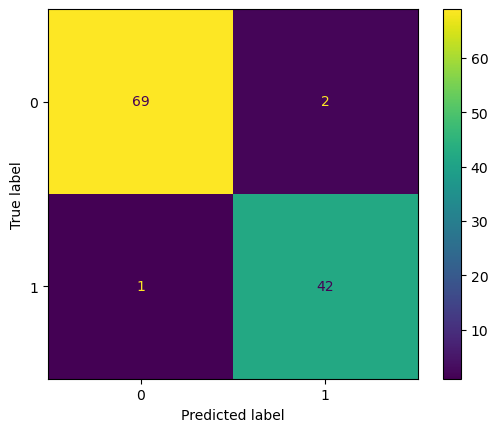

Epoch 1/10
15/15 [==============================] - 2s 41ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.1924 - val_accuracy: 0.9737
Epoch 2/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.1903 - val_accuracy: 0.9737
Epoch 3/10
15/15 [==============================] - 0s 10ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.1884 - val_accuracy: 0.9737
Epoch 4/10
15/15 [==============================] - 0s 10ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1869 - val_accuracy: 0.9737
Epoch 5/10
15/15 [==============================] - 0s 10ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.1855 - val_accuracy: 0.9737
Epoch 6/10
15/15 [==============================] - 0s 10ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.1843 - val_accuracy: 0.9737
Epoch 7/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1833 - val_accuracy: 0.9737
Epoch 8/10
15/1

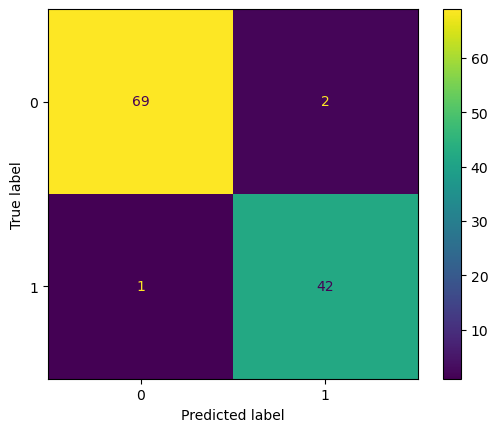

Epoch 1/10
15/15 [==============================] - 1s 36ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1574 - val_accuracy: 0.9649
Epoch 2/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1714 - val_accuracy: 0.9737
Epoch 3/10
15/15 [==============================] - 0s 5ms/step - loss: 5.3373e-04 - accuracy: 1.0000 - val_loss: 0.1835 - val_accuracy: 0.9737
Epoch 4/10
15/15 [==============================] - 0s 4ms/step - loss: 5.2293e-04 - accuracy: 1.0000 - val_loss: 0.1809 - val_accuracy: 0.9737
Epoch 5/10
15/15 [==============================] - 0s 5ms/step - loss: 4.6670e-04 - accuracy: 1.0000 - val_loss: 0.1803 - val_accuracy: 0.9737
Epoch 6/10
15/15 [==============================] - 0s 5ms/step - loss: 4.2222e-04 - accuracy: 1.0000 - val_loss: 0.1759 - val_accuracy: 0.9737
Epoch 7/10
15/15 [==============================] - 0s 5ms/step - loss: 3.8518e-04 - accuracy: 1.0000 - val_loss: 0.1792 - val_accuracy: 0.9737

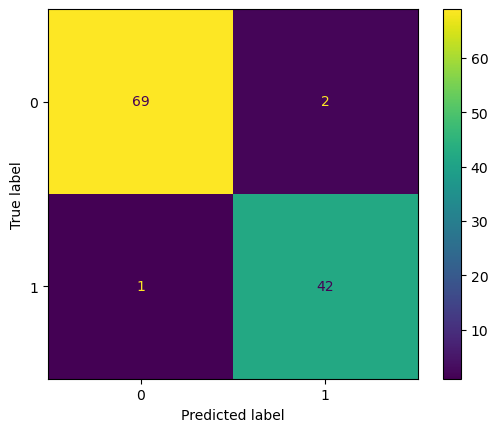

{0.9649122807017544: [2, 'adamax'], 0.9736842105263158: [3, 'adamax']}
Mejores resultados con los parámetros: [3, 'adamax']


In [57]:
optim = ["adam", "SGD", "RMSprop", "adagrad", "adamax"]
RN_combinaciones = {}

# Separa los atributos y la variable de salida
x = df.iloc[:, 2:32].values  
y = df.iloc[:, 1].values  

# Divide los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Escala los atributos para normalizarlos
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# ESTRUCTURA 1
RNmodel = Sequential()

# Agrega capas densas (totalmente conectadas) al modelo
RNmodel.add(Dense(64, activation='relu', input_shape=(30,)))  # Capa oculta 1
RNmodel.add(Dense(64, activation='relu'))  # Capa oculta 2
RNmodel.add(Dense(1, activation='sigmoid'))  # Capa de salida (1 nivel de salida)

for i in optim:
    # Compila el modelo
    RNmodel.compile(optimizer=i, loss='binary_crossentropy', metrics=['accuracy'])

    # Entrena el modelo
    RNmodel.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

    y_pred_prob = RNmodel.predict(x_test)
    y_pred = np.round(y_pred_prob)
    y_pred = np.round(np.nan_to_num(y_pred))
    
    # Calcular precisión
    precision = accuracy_score(y_test, y_pred)
    print("Precisión:", precision)

    # Calcular matriz de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:")
    ConfusionMatrixDisplay(matriz_confusion).plot()
    plt.show()
    
    RN_combinaciones[precision]=[1,i]
    
# ESTRUCTURA 2
RNmodel = Sequential()

# Agrega capas densas (totalmente conectadas) al modelo
RNmodel.add(Dense(128, activation='relu', input_shape=(30,)))  # Capa oculta 1
RNmodel.add(Dense(64, activation='relu'))  # Capa oculta 2
RNmodel.add(Dense(32, activation='relu'))  # Capa oculta 3
RNmodel.add(Dense(1, activation='sigmoid'))  # Capa de salida (1 nivel de salida)

for i in optim:
    # Compila el modelo
    RNmodel.compile(optimizer=i, loss='binary_crossentropy', metrics=['accuracy'])

    # Entrena el modelo
    RNmodel.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

    y_pred_prob = RNmodel.predict(x_test)
    y_pred = np.round(y_pred_prob)
    y_pred = np.round(np.nan_to_num(y_pred))
    
    # Calcular precisión
    precision = accuracy_score(y_test, y_pred)
    print("Precisión:", precision)

    # Calcular matriz de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:")
    ConfusionMatrixDisplay(matriz_confusion).plot()
    plt.show()
    
    RN_combinaciones[precision] = [2, i]
    
# ESTRUCTURA 3
RNmodel = Sequential()

# Agrega capas densas (totalmente conectadas) al modelo
RNmodel.add(Dense(64, activation='relu', input_shape=(30,)))  # Capa oculta 1
RNmodel.add(Dense(128, activation='relu'))  # Capa oculta 2
RNmodel.add(Dense(64, activation='relu'))  # Capa oculta 3
RNmodel.add(Dense(32, activation='relu'))  # Capa oculta 4
RNmodel.add(Dense(1, activation='sigmoid'))  # Capa de salida (1 nivel de salida)

for i in optim:
    # Compila el modelo
    RNmodel.compile(optimizer=i, loss='binary_crossentropy', metrics=['accuracy'])

    # Entrena el modelo
    RNmodel.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

    y_pred_prob = RNmodel.predict(x_test)
    y_pred = np.round(y_pred_prob)
    y_pred = np.round(np.nan_to_num(y_pred))
    # Calcular precisión
    precision = accuracy_score(y_test, y_pred)
    print("Precisión:", precision)

    # Calcular matriz de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:")
    ConfusionMatrixDisplay(matriz_confusion).plot()
    plt.show()
    
    RN_combinaciones[precision] = [3, i]
    
print(RN_combinaciones)
# Calculamos la precisión máxima
RN_max_prec = max(RN_combinaciones)
# Miramos con qué parámetros se consigue esta precisión
RN_mejor_vector_parametros = RN_combinaciones[RN_max_prec]
print("Mejores resultados con los parámetros:", RN_mejor_vector_parametros)


Epoch 1/10
15/15 [==============================] - 2s 33ms/step - loss: 0.5504 - accuracy: 0.8440 - val_loss: 0.3800 - val_accuracy: 0.9737
Epoch 2/10
15/15 [==============================] - 0s 8ms/step - loss: 0.3011 - accuracy: 0.9319 - val_loss: 0.1893 - val_accuracy: 0.9737
Epoch 3/10
15/15 [==============================] - 0s 6ms/step - loss: 0.1794 - accuracy: 0.9429 - val_loss: 0.1118 - val_accuracy: 0.9737
Epoch 4/10
15/15 [==============================] - 0s 8ms/step - loss: 0.1369 - accuracy: 0.9560 - val_loss: 0.0876 - val_accuracy: 0.9825
Epoch 5/10
15/15 [==============================] - 0s 8ms/step - loss: 0.1168 - accuracy: 0.9582 - val_loss: 0.0775 - val_accuracy: 0.9825
Epoch 6/10
15/15 [==============================] - 0s 8ms/step - loss: 0.1039 - accuracy: 0.9670 - val_loss: 0.0684 - val_accuracy: 0.9825
Epoch 7/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0947 - accuracy: 0.9736 - val_loss: 0.0628 - val_accuracy: 0.9825
Epoch 8/10
15/15 [=

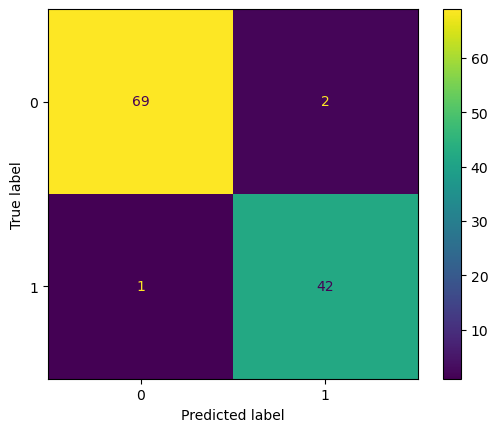

In [58]:
# Mejor modelo

RNmodel_mejor = Sequential()

if RN_mejor_vector_parametros[0]==1:
    RNmodel_mejor.add(Dense(64, activation='relu', input_shape=(30,)))  # Capa oculta 1
    RNmodel_mejor.add(Dense(64, activation='relu'))  # Capa oculta 2
    RNmodel_mejor.add(Dense(1, activation='sigmoid'))  # Capa de salida (1 nivel de salida)
elif RN_mejor_vector_parametros[0]==2:
    RNmodel_mejor.add(Dense(128, activation='relu', input_shape=(30,)))  # Capa oculta 1
    RNmodel_mejor.add(Dense(64, activation='relu'))  # Capa oculta 2
    RNmodel_mejor.add(Dense(32, activation='relu'))  # Capa oculta 3
    RNmodel_mejor.add(Dense(1, activation='sigmoid'))  # Capa de salida (1 nivel de salida)
elif RN_mejor_vector_parametros[0]==3:
    RNmodel_mejor.add(Dense(64, activation='relu', input_shape=(30,)))  # Capa oculta 1
    RNmodel_mejor.add(Dense(128, activation='relu'))  # Capa oculta 2
    RNmodel_mejor.add(Dense(64, activation='relu'))  # Capa oculta 3
    RNmodel_mejor.add(Dense(32, activation='relu'))  # Capa oculta 4
    RNmodel_mejor.add(Dense(1, activation='sigmoid'))  # Capa de salida (1 nivel de salida)
# Compila el modelo
RNmodel_mejor.compile(optimizer=RN_mejor_vector_parametros[1], loss='binary_crossentropy', metrics=['accuracy'])

# Entrena el modelo
RNmodel_mejor.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

y_pred_prob = RNmodel_mejor.predict(x_test)
y_pred = np.round(y_pred_prob)

# Calcular precisión
RN_mejor_prec = accuracy_score(y_test, y_pred)
print("Precisión:", RN_mejor_prec)

# Calcular matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
ConfusionMatrixDisplay(matriz_confusion).plot()
plt.show()

## KNN

[5, 0.9604395604395606]


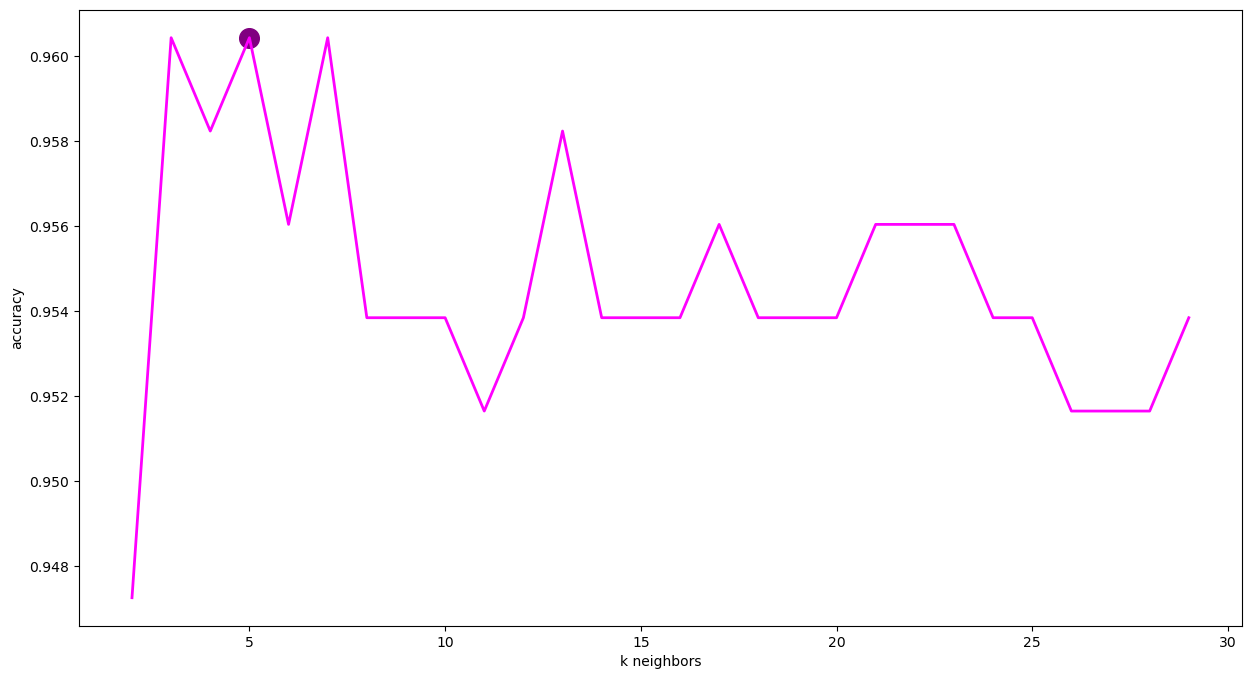

In [59]:
avg_score=[]
max_score=0
best_k=0
for k in range(2,30):
    knn_model=KNeighborsClassifier(n_jobs=-1,n_neighbors=k)
    score=cross_val_score(knn_model,x_train,y_train,n_jobs=-1,cv=5,scoring='accuracy')
    if score.mean()>max_score:
        max_score=score.mean()
        best_k=k
    avg_score.append(score.mean())

print([best_k,max(avg_score)])

max_index = avg_score.index(max(avg_score))
max_value = max(avg_score)

plt.figure(figsize=(15, 8))
plt.plot(range(2, 30), avg_score, color='magenta', linewidth=2)  
plt.scatter(max_index+2, max_value, color='purple', marker='o', s=200)  
plt.xlabel("k neighbors")
plt.ylabel("accuracy")

plt.show()

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

cross_value:  0.9669565217391304


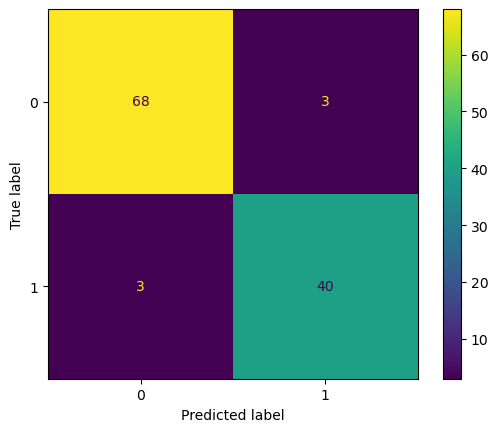

In [60]:
# modelo
KNN=KNeighborsClassifier(n_neighbors=best_k)
# entrenamos el modelo
KNN.fit(x_train,y_train)
# hacer predicciones
pred_KNN = KNN.predict(x_test)
# informe
print(classification_report(y_test,pred_KNN,zero_division=0))
# cross value
kfold = StratifiedKFold(10)
score = cross_val_score(
    KNN, x_train, y_train, cv=kfold, scoring="accuracy"
)
KNN_prec=score.mean()
print("cross_value: ", KNN_prec)
# matriz de confusión
mat_conf = confusion_matrix(y_test, pred_KNN)
ConfusionMatrixDisplay(mat_conf).plot()
plt.show()

# DIAGNOSIS

In [ ]:
nombre_v=str(input("Ahora introduciras los datos médicos del paciente con nombre o identificador: "))

radius_mean_v=float(input("radio (media): "))
texture_mean_v=float(input("textura (media): "))
perimeter_mean_v=float(input("perimetro (media): "))
area_mean_v=float(input("area (media): "))
smoothness_mean_v=float(input("suavidad (media): "))
compactness_mean_v=float(input("compacidad (media): "))
concavity_mean_v=float(input("concavidad (media): "))
concave_points_mean_v=float(input("puntos cóncavos (media): "))
symmetry_mean_v=float(input("simetría (media): "))
fractal_dimension_mean_v=float(input("dimensión fractal (media): "))

radius_se_v=float(input("radio (se): "))
texture_se_v=float(input("textura (se): "))
perimeter_se_v=float(input("perimetro (se): "))
area_se_v=float(input("area (se): "))
smoothness_se_v=float(input("suavidad (se): "))
compactness_se_v=float(input("compacidad (se): "))
concavity_se_v=float(input("concavidad (se): "))
concave_points_se_v=float(input("puntos cóncavos (se): "))
symmetry_se_v=float(input("simetría (se): "))
fractal_dimension_se_v=float(input("dimensión fractal (se): "))

radius_worst_v=float(input("radio (worst): "))
texture_worst_v=float(input("textura (worst): "))
perimeter_worst_v=float(input("perimetro (worst): "))
area_worst_v=float(input("area (worst): "))
smoothness_worst_v=float(input("suavidad (worst): "))
compactness_worst_v=float(input("compacidad (worst): "))
concavity_worst_v=float(input("concavidad (worst): "))
concave_points_worst_v=float(input("puntos cóncavos (worst): "))
symmetry_worst_v=float(input("simetría (worst): "))
fractal_dimension_worst_v=float(input("dimensión fractal (worst): "))

In [61]:
pac=[radius_mean_v, texture_mean_v, perimeter_mean_v, area_mean_v, smoothness_mean_v, compactness_mean_v, concavity_mean_v, concave_points_mean_v, symmetry_mean_v, fractal_dimension_mean_v, radius_se_v, texture_se_v, perimeter_se_v, area_se_v, smoothness_se_v, compactness_se_v, concavity_se_v, concave_points_se_v, symmetry_se_v, fractal_dimension_se_v, radius_worst_v, texture_worst_v, perimeter_worst_v, area_worst_v, smoothness_worst_v, compactness_worst_v, concavity_worst_v, concave_points_worst_v, symmetry_worst_v, fractal_dimension_worst_v]
#pac=[17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189]
#nombre_v="magali"

# Crear los DataFrames que necesitaremos
df_diagnostico = pd.DataFrame(columns=['Método', 'Características', 'Precisión', 'Diagnóstico'])

df_datos=pd.DataFrame({'medida':['radio(media)', 'textura(media)', 'perimetro(media)', 'area(media)', 'suavidad(media)', 'compacidad(media)', 'concavidad(media)', 'puntos_concavos(media)', 'simetria(media)', 'dimesion_fractal(media)', 'radio(se)', 'textura(se)', 'perimetro(se)', 'area(se)', 'suavidad(se)', 'compacidad(se)', 'concavidad(se)', 'puntos_concavos(se)', 'simetria(se)', 'dimesion_fractal(se)','radio(worst)', 'textura(worst)', 'perimetro(worst)', 'area(worst)', 'suavidad(worst)', 'compacidad(worst)', 'concavidad(worst)', 'puntos_concavos(worst)', 'simetria(worst)', 'dimesion_fractal(worst)'],
                     'valor':pac})

df_nombre=pd.DataFrame({'nombre':[nombre_v]})

# Predecir diagnóstico con diferentes métodos
DT_predict=int(DT_mejor.predict([pac]))
RF_predict=int(RF_mejor.predict([pac]))
pac_scaled = scaler.transform([pac])  # Escala el vector pac
y_pred_prob = RNmodel_mejor.predict(pac_scaled)
RN_predict = np.argmax(y_pred_prob, axis=1)
KNN_predict=int(KNN.predict([pac]))
    
df_diagnostico = df_diagnostico.append({'Método': 'Árbol de decisión', 'Características': DT_mejor_vector_parametros, 'Precisión': DT_mejor_prec, 'Diagnóstico': DT_predict}, ignore_index=True)
df_diagnostico = df_diagnostico.append({'Método': 'Random Forest', 'Características': RF_mejor_vector_parametros, 'Precisión': RF_mejor_prec, 'Diagnóstico': RF_predict}, ignore_index=True)
df_diagnostico = df_diagnostico.append({'Método': 'Redes neuronales', 'Características': RN_mejor_vector_parametros, 'Precisión': RN_mejor_prec, 'Diagnóstico': RN_predict[0]}, ignore_index=True)
df_diagnostico = df_diagnostico.append({'Método': 'KNN', 'Características': 'K='+ str(best_k), 'Precisión': KNN_prec, 'Diagnóstico': KNN_predict}, ignore_index=True)

df_diagnostico


1/1 [==============================] - 0s 41ms/step


C:\Users\Magali\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\Magali\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Magali\AppData\Local\Temp\ipykernel_2580\3479735925.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_diagnostico = df_diagnostico.append({'Método': 'Árbol de decisión', 'Características': DT_mejor_vector_parametros, 'Precisión': DT_mejor_prec, 'Diagnóstico': DT_predict}, ignore_index=True)
C:\Users\Magali\AppData\Local\Temp\ipykernel_2580\3479735925.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_diagnostico = df_dia

,Método,Características,Precisión,Diagnóstico
0,Árbol de decisión,"[entropy, sqrt, best, 0.3]",0.914551,1
1,Random Forest,"[entropy, log2, 0.2]",0.964879,1
2,Redes neuronales,"[3, adamax]",0.973684,0
3,KNN,K=5,0.966957,1


In [55]:
#Guardamos los dataset como csv
df_datos.to_csv("datospac_cancer_mama_py.csv", index=False)
df_diagnostico.to_csv("diagnostico_cancer_mama_py.csv", index=False)
df_nombre.to_csv("nombrepac_cancer_mama_py.csv", index=False)
